## IMPORTACIONES Y CONFIGURACION INICIAL

In [137]:
!pip install boto3 pandas matplotlib

import boto3
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
import numpy as np
import plotly.express as px

In [138]:
# Configuración del cliente S3
bucket_name = "xideralaws-curso-yalbani"
s3 = boto3.client("s3")

In [139]:
# Función para leer un archivo CSV desde S3 usando StringIO
def read_csv_from_s3(bucket, key):
    response = s3.get_object(Bucket=bucket, Key=key)
    # Leer el contenido del archivo como texto
    try:
        csv_content = response['Body'].read().decode('utf-8')
    except UnicodeDecodeError:
        csv_content = response['Body'].read().decode('ISO-8859-1') 
    return pd.read_csv(StringIO(csv_content))

In [140]:
# Función para guardar df
def save_csv_to_s3(dataframe, bucket, key):
    """Guarda un DataFrame como CSV en S3"""
    csv_buffer = StringIO()
    dataframe.to_csv(csv_buffer, index=False)
    s3.put_object(
        Bucket=bucket,
        Key=key,
        Body=csv_buffer.getvalue()
    )
    print(f" Guardado exitosamente: s3://{bucket}/{key}")

In [141]:
# --- Cargar y Preparar Datos ---
print("🔄 Cargando datos desde S3...")
key_b1 = "B1/B1.csv"
key_stadiums = "datos_crudos/Football Stadiums.csv"
key_results = "datos_crudos/results.csv"

df_results = read_csv_from_s3(bucket_name, key_results)
df_b1 = read_csv_from_s3(bucket_name, key_b1)
df_stadiums = read_csv_from_s3(bucket_name, key_stadiums)

print("Bases de datos cargadas.")

🔄 Cargando datos desde S3...
Bases de datos cargadas.


### LIMPIEZA

In [142]:
# --- Limpieza de la Columna STADIUM ---

def clean_stadium_name(name):
    """
    Limpia el nombre del estadio: elimina 'Estadio'/'Stadium' y toma las primeras 7 letras para compararlas.
    """
    if pd.isna(name):
        return name
    name = str(name).upper()
    # Eliminar las palabras "STADIUM" o "ESTADIO"
    name = name.replace('STADIUM', '').replace('ESTADIO', '').strip()
    # Tomar las primeras 7 letras restantes
    return name[:7]

#### B1/B1.csv

#### Football Stadiums.csv

In [143]:
# Aplicar la limpieza a ambas bases
df_b1['STADIUM_KEY'] = df_b1['STADIUM'].apply(clean_stadium_name)
df_stadiums['STADIUM_KEY'] = df_stadiums['Stadium'].apply(clean_stadium_name)

In [144]:
# Preparar datos de estadios
df_stadiums_slim = df_stadiums[['STADIUM_KEY', 'Stadium', 'Capacity']].copy()
# Eliminar duplicados en la tabla de estadios por la clave
df_stadiums_slim.drop_duplicates(subset=['STADIUM_KEY'], inplace=True)

In [145]:
# --- Limpiar capacidad y asistencia ---
# forzar errores a NaN
df_b1['HIGHEST_ATTENDANCE'] = pd.to_numeric(
    df_b1['HIGHEST_ATTENDANCE'].astype(str).str.replace(',', '', regex=False),
    errors='coerce'
)
df_stadiums_slim['Capacity'] = pd.to_numeric(
    df_stadiums_slim['Capacity'].astype(str).str.replace(',', '', regex=False),
    errors='coerce'
)


In [146]:
# Merge y análisis
df_comparacion = pd.merge(df_b1, df_stadiums_slim, on='STADIUM_KEY', how='left')
df_analisis_asistencia = df_comparacion.dropna(subset=['HIGHEST_ATTENDANCE', 'Capacity']).copy()

In [147]:
# Calcular porcentajes
df_analisis_asistencia['Porcentaje_Llenado'] = (
    df_analisis_asistencia['HIGHEST_ATTENDANCE'] / df_analisis_asistencia['Capacity']
) * 100
df_analisis_asistencia['Diferencia_Absoluta'] = (
    df_analisis_asistencia['Capacity'] - df_analisis_asistencia['HIGHEST_ATTENDANCE']
)
df_analisis_asistencia['Porcentaje_Llenado'] = np.clip(
    df_analisis_asistencia['Porcentaje_Llenado'], a_min=None, a_max=100
)

In [148]:
# Tabla final
tabla_final = df_analisis_asistencia[[
    'Year', 'COUNTRY', 'STADIUM', 'Stadium', 
    'HIGHEST_ATTENDANCE', 'Capacity', 'Porcentaje_Llenado', 'Diferencia_Absoluta'
]].sort_values(by='Porcentaje_Llenado', ascending=False)

print(f"Tabla de asistencia completada: {len(tabla_final)} registros")
save_csv_to_s3(tabla_final, bucket_name, "datos_limpios/tabla_final.csv")

Tabla de asistencia completada: 28 registros
 Guardado exitosamente: s3://xideralaws-curso-yalbani/datos_limpios/tabla_final.csv


## GUARDAR tabla_final

### VISUALIZACION

In [149]:
# porcentaje de llenado (Top 10)
top_10_grafico = tabla_final.head(10).sort_values(by='Porcentaje_Llenado', ascending=True)
top_10_grafico['Estadio_Evento'] = top_10_grafico['STADIUM'] + ' (' + top_10_grafico['Year'].astype(str) + ')'

In [150]:
# Mostrar el top 10
print("\n" + "="*80)
print("Tabla de Comparación: Asistencia Máxima vs. Capacidad del Estadio")
print(tabla_final.round(2).head(10)) 


Tabla de Comparación: Asistencia Máxima vs. Capacidad del Estadio
    Year        COUNTRY                           STADIUM  \
0   1930        Uruguay    Estadio Centenario, Montevideo   
1   1934          Italy        Stadio Nazionale PNF, Rome   
5   1958         Sweden        Ullevi Stadium, Gothenburg   
6   1962          Chile        Estadio Nacional, Santiago   
7   1966        England           Wembley Stadium, London   
9   1974   West Germany            Olympiastadion, Munich   
10  1978      Argentina  Estadio Monumental, Buenos Aires   
14  1994  United States   Rose Bowl, Pasadena, California   
17  2006        Germany            Olympiastadion,ÿBerlin   
15  1998         France      Stade de France, Saint-Denis   

                              Stadium  HIGHEST_ATTENDANCE  Capacity  \
0                   Centenary Stadium             93000.0    2000.0   
1             Stadio Georgios Kamaras             55000.0   14200.0   
5                      Ullevi Stadion           

In [151]:
tabla_final.tail(10)

,Year,COUNTRY,STADIUM,Stadium,HIGHEST_ATTENDANCE,Capacity,Porcentaje_Llenado,Diferencia_Absoluta
11,1982,Spain,"Camp Nou, Barcelona",Camp Nou,95500.0,99354.0,96.120941,3854.0
19,2014,Brazil,"MaracanÆ Stadium, Rio de Janeiro",Maracanã,74738.0,78838.0,94.799462,4100.0
23,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,45334.0,48000.0,94.445833,2666.0
65,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,44851.0,48000.0,93.439583,3149.0
70,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,44846.0,48000.0,93.429167,3154.0
40,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,44833.0,48000.0,93.402083,3167.0
54,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,44569.0,48000.0,92.852083,3431.0
48,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,44374.0,48000.0,92.445833,3626.0
84,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,44137.0,48000.0,91.952083,3863.0
31,2022,Qatar,Khalifa International Stadium,Khalifa Stadium,42608.0,48000.0,88.766667,5392.0


In [152]:
tabla_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 0 to 31
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 28 non-null     int64  
 1   COUNTRY              28 non-null     object 
 2   STADIUM              28 non-null     object 
 3   Stadium              28 non-null     object 
 4   HIGHEST_ATTENDANCE   28 non-null     float64
 5   Capacity             28 non-null     float64
 6   Porcentaje_Llenado   28 non-null     float64
 7   Diferencia_Absoluta  28 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 2.0+ KB


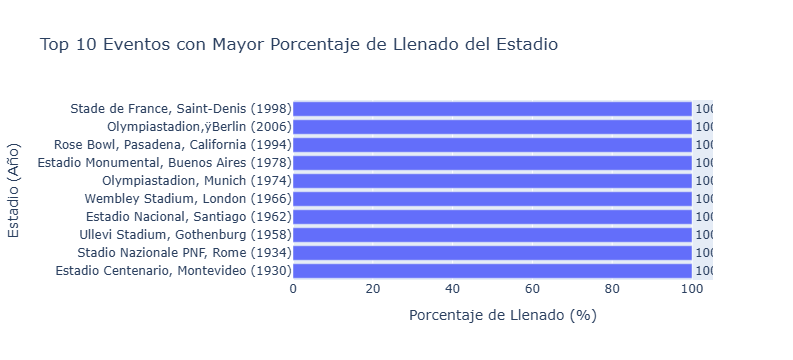

In [153]:
# --- Grafica ---
fig = px.bar(
    top_10_grafico, 
    x='Porcentaje_Llenado', 
    y='Estadio_Evento', 
    orientation='h',
    title='Top 10 Eventos con Mayor Porcentaje de Llenado del Estadio',
    labels={'Porcentaje_Llenado': 'Porcentaje de Llenado (%)', 'Estadio_Evento': 'Estadio (Año)'},
    text='Porcentaje_Llenado'
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show() 

In [154]:
# --- Seleccionar el Antitop 10 (tail(10)) ---
antitop_10_grafico = tabla_final.tail(10).sort_values(by='Porcentaje_Llenado', ascending=True)
antitop_10_grafico['Estadio_Evento'] = antitop_10_grafico['STADIUM'] + ' (' + antitop_10_grafico['Year'].astype(str) + ')'

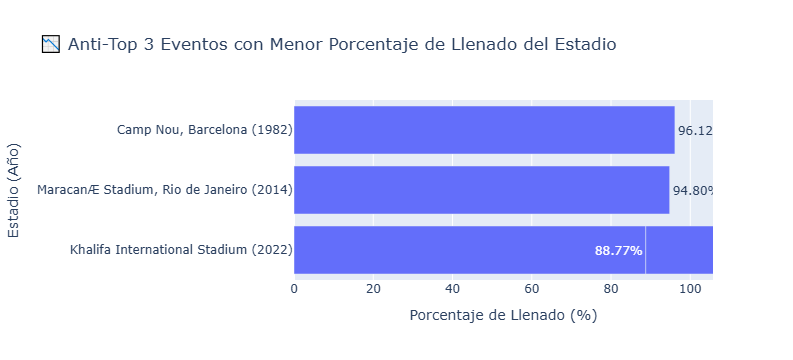

In [155]:
fig_antitop = px.bar(
    antitop_10_grafico, 
    x='Porcentaje_Llenado', 
    y='Estadio_Evento', 
    orientation='h', # horizontal para mejor lectura de etiquetas
    title='📉 Anti-Top 3 Eventos con Menor Porcentaje de Llenado del Estadio',
    labels={'Porcentaje_Llenado': 'Porcentaje de Llenado (%)', 'Estadio_Evento': 'Estadio (Año)'},
    text='Porcentaje_Llenado'
)

# Configurar texto en la barra
fig_antitop.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
# eje X inicie en 0 y sea legible
fig_antitop.update_layout(xaxis=dict(range=[0, antitop_10_grafico['Porcentaje_Llenado'].max() * 1.1]))
fig_antitop.show()

#### Stadiums por paises host

In [156]:
# --- Definir los países a filtrar ---
paises_host = ['Mexico', 'Canada', 'United States of America']

# Filtrar por países
country_col_limpia = df_stadiums['Country'].astype(str).str.lower().str.strip()
paises_filtro = [p.lower().strip() for p in paises_host]
df_filtrado_paises = df_stadiums[country_col_limpia.isin(paises_filtro)].copy()

In [157]:
# --- Limpiar y Preparar por Capacidad ---
# Preparar datos de capacidad
df_capacidad_estadio = df_filtrado_paises[['Country', 'Stadium', 'Capacity']].copy()
df_capacidad_estadio['Capacity'] = pd.to_numeric(
    df_capacidad_estadio['Capacity'].astype(str).str.replace(',', '', regex=False),
    errors='coerce'
)

In [158]:
df_grafica_individual

,Country,Stadium,Capacity
1955,United States of America,Pier 40,500
1008,Mexico,Estadio Borregos,2000
1870,United States of America,Al Lang Stadium,7500
1983,United States of America,Toyota Field,8296
1949,United States of America,NSC Stadium,8500
...,...,...,...
1923,United States of America,Kyle Field,102733
1951,United States of America,Ohio Stadium,104944
1882,United States of America,Beaver Stadium,106572
1943,United States of America,Michigan Stadium,107601


## GUARDAR df_grafica_individual

In [159]:
df_grafica_individual = df_capacidad_estadio.dropna(subset=['Capacity']).copy()
df_grafica_individual.sort_values(by='Capacity', ascending=True, inplace=True)
print(f"Estadios filtrados: {len(df_grafica_individual)}")
save_csv_to_s3(df_grafica_individual, bucket_name, "datos_limpios/df_grafica_individual.csv")

Estadios filtrados: 171
 Guardado exitosamente: s3://xideralaws-curso-yalbani/datos_limpios/df_grafica_individual.csv


In [160]:
# ---Limpieza y Conversion a Número ---
def clean_and_convert_to_float(df, col_name):
    """Convierte una columna con formato de coma (ej: "35,464") a float."""
    cleaned_series = df[col_name].astype(str).str.replace(',', '', regex=False).replace('N/A', np.nan)
    return pd.to_numeric(cleaned_series, errors='coerce')

In [161]:
# Tabla resumen por país
tabla_resumen_capacidad = df_capacidad_estadio.groupby('Country').agg(
    Estadios_Unicos=('Stadium', 'nunique'),
    Capacidad_Promedio=('Capacity', 'mean'),
    Capacidad_Maxima=('Capacity', 'max'),
    Capacidad_Total_Asientos=('Capacity', 'sum')
).reset_index()

tabla_ordenada_max = tabla_resumen_capacidad.sort_values(by='Capacidad_Maxima', ascending=False)
tabla_resumen_capacidad.info()

if 'Capacidad_Maxima' not in tabla_resumen_capacidad.columns:
    tabla_resumen_capacidad['Capacidad_Maxima'] = clean_and_convert_to_float(tabla_resumen_capacidad, 'Capacidad_Maxima')

tabla_ordenada_max = tabla_resumen_capacidad.sort_values(
    by='Capacidad_Maxima', 
    ascending=False
)

tabla_resumen_capacidad['Capacidad_Maxima_Num'] = clean_and_convert_to_float(tabla_resumen_capacidad, 'Capacidad_Maxima')
tabla_resumen_capacidad['Capacidad_Promedio_Num'] = clean_and_convert_to_float(tabla_resumen_capacidad, 'Capacidad_Promedio')


print(f"Resumen por país completado")
save_csv_to_s3(tabla_ordenada_max, bucket_name, "datos_limpios/tabla_ordenada_max.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   3 non-null      object 
 1   Estadios_Unicos           3 non-null      int64  
 2   Capacidad_Promedio        3 non-null      float64
 3   Capacidad_Maxima          3 non-null      int64  
 4   Capacidad_Total_Asientos  3 non-null      int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 252.0+ bytes
Resumen por país completado
 Guardado exitosamente: s3://xideralaws-curso-yalbani/datos_limpios/tabla_ordenada_max.csv


## GUARDAR tabla_ordenada_max

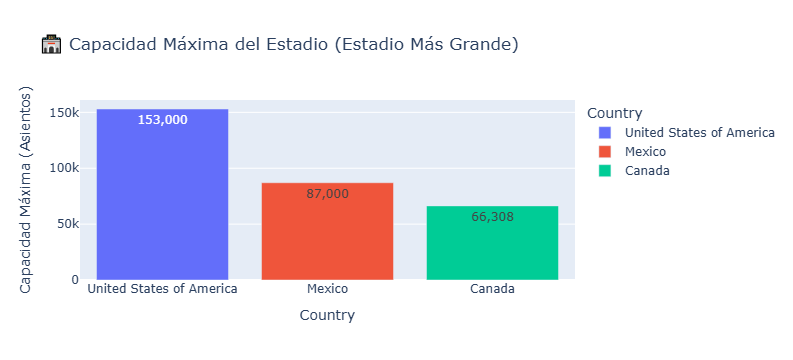

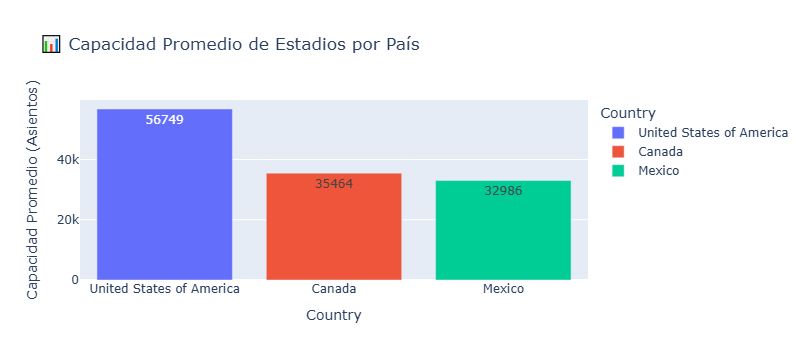

In [162]:
# --- Gráfico de Capacidad Máxima ---
fig_max = px.bar(
    tabla_resumen_capacidad.sort_values(by='Capacidad_Maxima', ascending=False),
    x='Country',
    y='Capacidad_Maxima',
    color='Country',
    title='🏟️ Capacidad Máxima del Estadio (Estadio Más Grande)',
    labels={'Capacidad_Maxima': 'Capacidad Máxima (Asientos)'},
)
fig_max.update_traces(texttemplate='%{y:,}', textposition='inside')
fig_max.show()

# --- Capacidad Promedio ---
fig_avg = px.bar(
    tabla_resumen_capacidad.sort_values(by='Capacidad_Promedio', ascending=False),
    x='Country',
    y='Capacidad_Promedio',
    color='Country',
    title='📊 Capacidad Promedio de Estadios por País',
    labels={'Capacidad_Promedio': 'Capacidad Promedio (Asientos)'},
)
fig_avg.update_traces(texttemplate='%{y:.0f}', textposition='inside')
fig_avg.show()

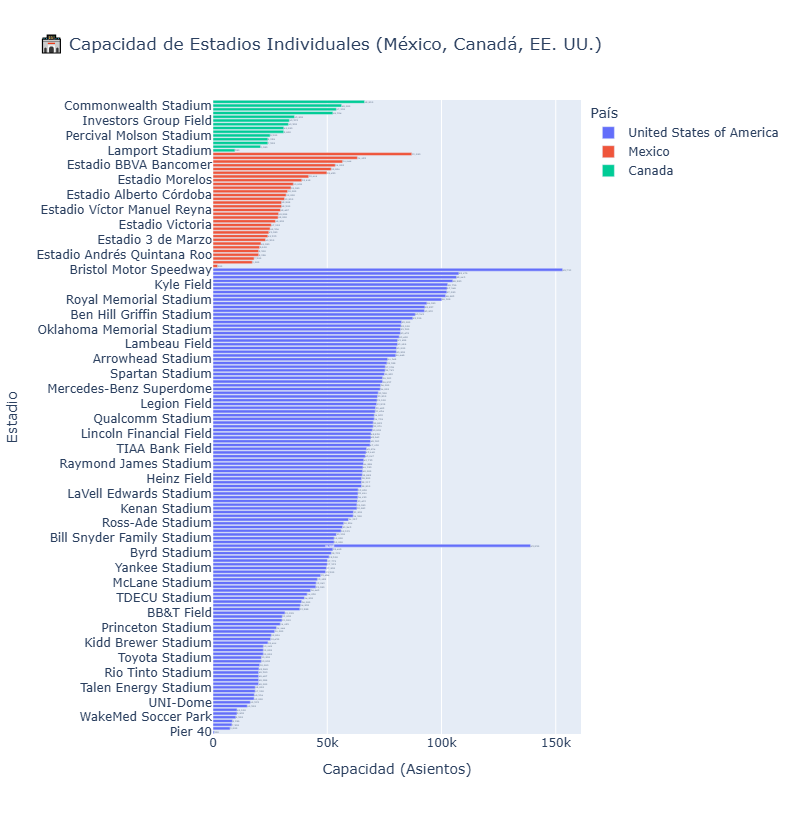

In [163]:
# --- Gráfico de Barras ---
fig_todos_estadios = px.bar(
    df_grafica_individual,
    x='Capacity',
    y='Stadium',
    color='Country',
    orientation='h',
    title='🏟️ Capacidad de Estadios Individuales (México, Canadá, EE. UU.)',
    labels={
        'Capacity': 'Capacidad (Asientos)',
        'Stadium': 'Estadio',
        'Country': 'País'
    },
    height=800,
    width=1000 
)

fig_todos_estadios.update_traces(
    text=df_grafica_individual['Capacity'].apply(lambda x: f"{int(x):,}"),
    texttemplate='%{text}',
    textposition='outside'
)

fig_todos_estadios.show()

#### results.csv

In [164]:
df_results['home_score'] = pd.to_numeric(df_results['home_score'], errors='coerce')
df_results['away_score'] = pd.to_numeric(df_results['away_score'], errors='coerce')

In [165]:
if not df_results.empty:
    # Calcular totales
    df_results['total_goles'] = df_results['home_score'] + df_results['away_score']
    df_results['home_win'] = df_results['home_score'] > df_results['away_score']
    
    # Partidos con más de 4 goles
    df_goles_altos = df_results[df_results['total_goles'] > 4].copy()
    
    # Análisis por país
    df_analisis_victoria = df_goles_altos.groupby('country').agg(
        Total_Partidos=('home_team', 'size'),
        Total_Victorias_Local=('home_win', 'sum')
    ).reset_index()
    
    df_analisis_victoria['Porcentaje_Victoria_Local'] = (
        df_analisis_victoria['Total_Victorias_Local'] / df_analisis_victoria['Total_Partidos']
    ) * 100

    max_partidos = df_analisis_victoria['Total_Partidos'].max()
    min_partidos = df_analisis_victoria['Total_Partidos'].min()
    
    df_analisis_victoria = df_analisis_victoria.sort_values('Total_Partidos', ascending=False)
    
    print(f"Análisis de victorias completado: {len(df_analisis_victoria)} países")
    save_csv_to_s3(df_analisis_victoria, bucket_name, "datos_limpios/df_analisis_victoria.csv")
  

Análisis de victorias completado: 263 países
 Guardado exitosamente: s3://xideralaws-curso-yalbani/datos_limpios/df_analisis_victoria.csv


In [166]:
df_analisis_victoria.head(15)

,country,Total_Partidos,Total_Victorias_Local,Porcentaje_Victoria_Local
222,Sweden,226,153,67.699115
244,United States,221,120,54.298643
78,France,180,126,70.000000
136,Malaysia,177,121,68.361582
70,England,173,127,73.410405
85,Germany,161,119,73.913043
231,Thailand,142,75,52.816901
156,Netherlands,132,103,78.030303
30,Brazil,131,93,70.992366
102,Hungary,130,89,68.461538


## GUARDAR df_analisis_victoria

In [197]:
# Conteo de goles
# Contar la frecuencia de cada valor de 'total_goles' (5, 6, 7, etc.)
df_conteo_goles = df_goles_altos.groupby('total_goles').size().reset_index(name='Total_Encuentros')
df_conteo_goles['total_goles_str'] = df_conteo_goles['total_goles'].astype(str) + ' goles'

#Goles en TODOS los partidos (0 o más goles)
total_goles_global = df_results['total_goles'].sum()

#Goles en partidos de ALTA anotación (> 4 goles)
total_goles_alta_anotacion = df_goles_altos['total_goles'].sum()

#Goles en partidos de BAJA anotación (0 a 4 goles)
total_goles_baja_anotacion = total_goles_global - total_goles_alta_anotacion

#Porcentaje que NO está en el gráfico (Baja Anotación)
porcentaje_baja_anotacion = (total_goles_baja_anotacion / total_goles_global) * 100

total_goles_anotados = df_goles_altos['total_goles'].sum()
df_conteo_goles = df_goles_altos.groupby('total_goles').size().reset_index(name='Total_Encuentros')
df_conteo_goles['total_goles_str'] = df_conteo_goles['total_goles'].astype(str) + ' goles'
    
print(f" Conteo de goles completado")
save_csv_to_s3(df_conteo_goles, bucket_name, "datos_limpios/df_conteo_goles.csv")

 Conteo de goles completado
 Guardado exitosamente: s3://xideralaws-curso-yalbani/datos_limpios/df_conteo_goles.csv


## GUARDAR df_conteo_goles

#### OTRO ANALISIS

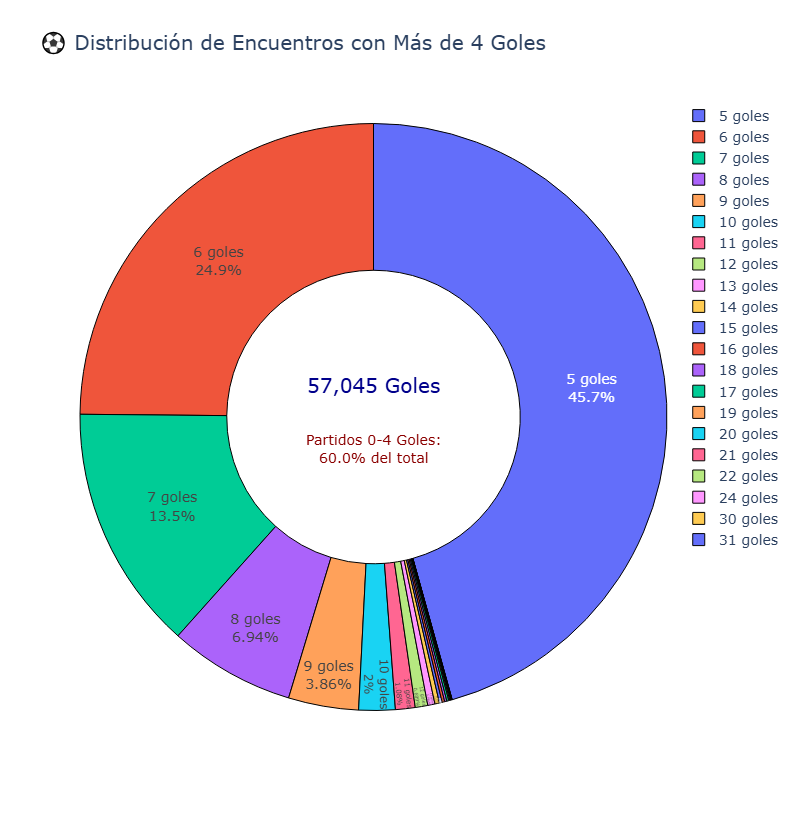

In [198]:
# --- Gráfico de Pie ---
fig_goles_pie = px.pie(
    df_conteo_goles,
    names='total_goles_str', # Nombres de las secciones (5 goles, 6 goles, etc.)
    values='Total_Encuentros', # Valores para determinar el tamaño de la sección
    title='⚽ Distribución de Encuentros con Más de 4 Goles',
    hole=0.5, # Crea un gráfico de dona
    color='total_goles_str',
    height=800,
    width=800,
    labels={
        'total_goles_str': 'Goles Totales en el Partido',
        'Total_Encuentros': 'Número de Partidos'
    }
)

fig_goles_pie.update_traces(
    textposition='inside', 
    textinfo='percent+label', # porcentaje y etiqueta (ej: 30% - 5 goles)
    marker=dict(line=dict(color='#000000', width=1)) # borde negro para mejor contraste
)

fig_goles_pie.update_layout(
    font=dict(size=14),
    annotations=[
        dict(
            text=f"{total_goles_alta_anotacion:,} Goles", 
            x=0.5, y=0.55, # Posición ligeramente arriba del centro
            font=dict(size=20, color='darkblue'),
            showarrow=False
        ),
        # PORCENTAJE DE GOLES BAJOS (lo que no se ve)
        dict(
            text=f"Partidos 0-4 Goles:<br>{porcentaje_baja_anotacion:.1f}% del total",
            x=0.5, y=0.45, # Posición ligeramente abajo del centro
            font=dict(size=14, color='darkred'),
            showarrow=False
        )
    ]
)

fig_goles_pie.show()

In [169]:
df_b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          86 non-null     int64  
 1   COUNTRY                       86 non-null     object 
 2   Total_attendance_?            22 non-null     object 
 3   Matches                       22 non-null     float64
 4   Average_attendance            22 non-null     object 
 5   HIGHEST_ATTENDANCE            85 non-null     float64
 6   STADIUM                       86 non-null     object 
 7   Top_scorers                   86 non-null     object 
 8   Goals_scored                  22 non-null     float64
 9   Budget(Billion_US$)           9 non-null      float64
 10  Total_Fund(dollars)           11 non-null     object 
 11  Winnin_team_payment(dollars)  6 non-null      object 
 12  STADIUM_KEY                   86 non-null     object 
dtypes: floa

#### OTRO ANALISIS

In [187]:
def clean_to_millions(series):
    """
    Convierte valores a millones limpiando caracteres especiales y manejando
    las notaciones 'M' (millones) y 'B'/'Billion' (billones).
    """
    series_clean = series.astype(str).str.lower().str.strip()
    series_clean = series_clean.str.replace(r'[$,]', '', regex=True).str.replace(' ', '', regex=False)
    series_clean = series_clean.str.replace('usd', '', regex=False)
    
    def convert_value(val):
        if pd.isna(val) or not isinstance(val, str) or val in ('nan', 'none', 'n/a'):
            return np.nan
        
        if 'b' in val or 'billion' in val:
            val = val.replace('b', '').replace('illion', '').replace('n', '')
            try:
                return float(val) * 1000 # Billones a Millones
            except ValueError:
                return np.nan
        
        if 'm' in val or 'million' in val:
            val = val.replace('m', '').replace('illion', '').replace('n', '')

        try:
            numeric_value = float(val)
            # Si el valor es > 1,000,000 (dólares), lo dividimos por 1M
            if numeric_value > 1000000:
                return numeric_value / 1000000 
            # Si es un número pequeño (ej. 42), asumimos que ya está en millones
            return numeric_value
        except ValueError:
            return np.nan

    return series_clean.apply(convert_value)

In [188]:
df_analisis = df_b1[['Year', 'Budget(Billion_US$)', 'Total_Fund(dollars)', 'Winnin_team_payment(dollars)']].copy()
# Limpiar y convertir a millones
df_analisis['Total_Fund_Millions'] = clean_to_millions(df_analisis['Total_Fund(dollars)'])
df_analisis['Winnin_Payment_Millions'] = clean_to_millions(df_analisis['Winnin_team_payment(dollars)'])
# El presupuesto ya está en Billones (Budget(Billion_US$)), lo convertimos a Millones de USD (x 1000)
df_analisis['Budget_Millions'] = df_analisis['Budget(Billion_US$)'] * 1000

In [189]:
# Agrupar por año y eliminar filas donde faltan los datos CLAVE para la proyección
df_historico = df_analisis.groupby('Year', as_index=False).agg({
    'Total_Fund_Millions': 'first',
    'Winnin_Payment_Millions': 'first',
    'Budget_Millions': 'first'
}).dropna(subset=['Total_Fund_Millions', 'Winnin_Payment_Millions']).sort_values('Year').reset_index(drop=True)

if df_historico.shape[0] < 1:
    print("ERROR: No hay datos válidos de 'Total_Fund' para realizar la gráfica.")
    df_grafico = pd.DataFrame()
else:
    # Calcular Tasa de Crecimiento Anual Promedio (si hay al menos 2 puntos)
    if df_historico.shape[0] >= 2:
        df_historico['Winnin_Growth'] = df_historico['Winnin_Payment_Millions'].pct_change(fill_method=None)
        avg_growth_rate = df_historico['Winnin_Growth'].mean()

        # Usar una tasa de respaldo si el cálculo falla
        if pd.isna(avg_growth_rate) or avg_growth_rate <= 0:
            avg_growth_rate = 0.119 
    else:
        # Usar la tasa de respaldo si solo hay 1 punto de datos
        avg_growth_rate = 0.119

    # Proyección (usando el último valor disponible del Total Fund)
    last_row = df_historico.iloc[-1]
    last_year = last_row['Year']
    last_fund = last_row['Total_Fund_Millions']
    
    projected_fund_2026 = last_fund * (1 + avg_growth_rate)

    # Crear DataFrame final para gráficos
    df_grafico = df_historico[['Year', 'Total_Fund_Millions']].copy()
    df_grafico['Tipo'] = 'Histórico'

    df_proyeccion = pd.DataFrame([{
        'Year': 2026, 
        'Total_Fund_Millions': projected_fund_2026,
        'Tipo': 'Proyección'
    }])

    df_grafico = pd.concat([df_grafico, df_proyeccion], ignore_index=True)
    
    print(f" Proyección financiera completada")
    print(f"  Tasa de crecimiento promedio: {avg_growth_rate:.2%}")
    print(f"  Proyección 2026: ${projected_fund_2026:.1f}M")
    
    save_csv_to_s3(df_grafico, bucket_name, "datos_limpios/df_proyeccion_financiera.csv")

 Proyección financiera completada
  Tasa de crecimiento promedio: 56.67%
  Proyección 2026: $1566.7M
 Guardado exitosamente: s3://xideralaws-curso-yalbani/datos_limpios/df_proyeccion_financiera.csv


## GUARDAR df_grafico

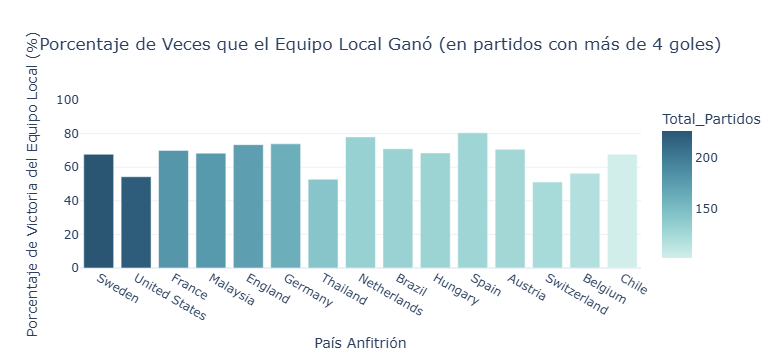

In [175]:
df_visual = df_analisis_victoria[df_analisis_victoria['Total_Partidos'] >= min_partidos].head(15)
fig = px.bar(
    df_visual, 
    x='country',
    y='Porcentaje_Victoria_Local',
    title="Porcentaje de Veces que el Equipo Local Ganó (en partidos con más de 4 goles)",
    color='Total_Partidos', # Usar el número de partidos como color para contexto
    color_continuous_scale=px.colors.sequential.Teal,
    template='plotly_white'
)
fig.update_layout(
    xaxis_title="País Anfitrión",
    yaxis_title="Porcentaje de Victoria del Equipo Local (%)",
    yaxis_range=[0, 100] # Asegurar que el eje Y vaya de 0 a 100
)

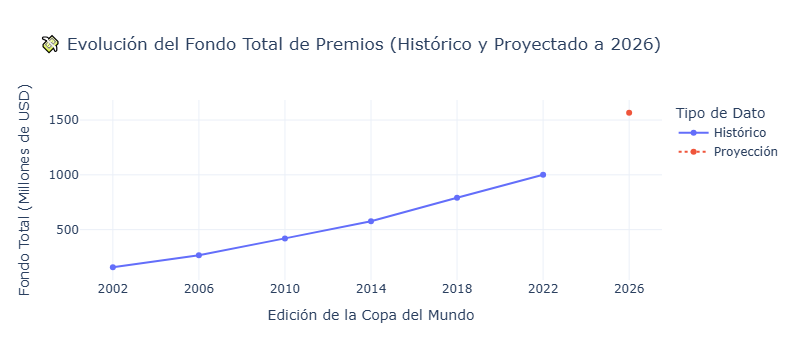

In [190]:
if not df_historico.empty:
    
    df_grafico['Year_str'] = df_grafico['Year'].astype(str)
    
    fig = px.line(
        df_grafico,
        x='Year_str',
        y='Total_Fund_Millions',
        color='Tipo', # Para diferenciar Histórico de Proyección
        line_dash='Tipo', 
        markers=True,
        title='💸 Evolución del Fondo Total de Premios (Histórico y Proyectado a 2026)',
        labels={
            'Year_str': 'Edición (Año)',
            'Total_Fund_Millions': 'Fondo Total (Millones de USD)',
            'Tipo': 'Tipo de Dato'
        },
        template='plotly_white'
    )
    
    # Ajustar el eje X para que no se vean demasiado apretados
    fig.update_xaxes(tickmode='linear')
    
    # Ajustar etiquetas y añadir valores
    fig.update_traces(
        mode='lines+markers', 
        text=df_grafico['Total_Fund_Millions'].apply(lambda x: f"${x:.0f}M"), 
        textposition="top center"
    )
    
    fig.update_layout(
        xaxis_title="Edición de la Copa del Mundo",
        yaxis_title="Fondo Total (Millones de USD)"
    )
    
    fig.show()

else:
    print("El DataFrame de la gráfica está vacío. Verifique los nulos y la función de limpieza.")